In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import signal
import copy

In [2]:
class Profile:
    def __init__(self,std,im_size):
        self.mid_pixel = int(im_size/2) # 128/2
        self.x, self.y = self.mid_pixel, self.mid_pixel
        self.im_size = im_size
        self.std = std
        self.noise = False
        self.lam = 0.1133929878
        
        gkern1d = signal.gaussian(self.im_size, std=std).reshape(self.im_size, 1)
        self.im = np.outer(gkern1d, gkern1d)
        
        self.im_lrud  = None
        self.im_lr = None
        self.im_ud = None

    def __repr__(self):
        """
        print cluster metadata
        """
        return str(self.im)
    
    def to_pandas(self):
        """
        convert metadata (as recarray) to pandas DataFrame
        """
        self.meta = pd.DataFrame(self.meta)
        return
    
    def add_noise(self):
        """
        add Poisson noise to cluster im matrix
        """
        self.noise = np.random.poisson(lam=self.lam, size=self.im.shape)
        self.im += self.noise
        return
        
    def shift(self):
        """
        shift cluster randomly within bounds of im
        """
        """
        shift cluster randomly within bounds of im
        """
        r = self.std
        mid = self.mid_pixel #center pixel index of 384x384 image
        delta = self.im_size - self.mid_pixel - r - 10
        
        x = np.random.randint(low=-1*delta,high=delta,size=1)[0]
        y = np.random.randint(low=-1*delta,high=delta,size=1)[0]

        self.x += x
        self.y += y
        im_shift = np.roll(self.im,shift=y,axis=0)
        self.im = np.roll(im_shift,shift=x,axis=1)
        
        return 
    
    def plot(self,spath='../figs/profile/'):
        """
        plot image
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(self.im,interpolation='none',cmap='viridis')
        
        ticks = np.arange(0,self.size,50)
        plt.xticks(ticks),plt.yticks(ticks)

        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.12)

        plt.colorbar(im, cax=cax)
        # plt.show()
        plt.close()
        
        return None

    def flip_lr(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1
        
        im_lr = np.fliplr(self.im)
        im_c_lr = np.flipud(im_c)
        
        self.im_lr = im_lr
        self.x_lr, self.y_lr = [val[0] for val in np.nonzero(im_c_lr)]
        
        self.im = im_lr
        self.x, self.y = self.x_lr, self.y_lr
        return None

    def flip_ud(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1

        im_ud = np.flipud(self.im)
        im_c_ud = np.fliplr(im_c)
        
        self.im_ud = im_ud
        self.x_ud, self.y_ud = [val[0] for val in np.nonzero(im_c_ud)]
        
        self.im = im_ud
        self.x, self.y = self.x_ud, self.y_ud
        return None
    
    def flip_lrud(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1
        
        im_lrud = np.fliplr(np.flipud(self.im))
        im_c_lrud = np.flipud(np.fliplr(im_c))
        
        self.im_lrud = im_lrud
        self.x_lrud, self.y_lrud = [val[0] for val in np.nonzero(im_c_lrud)]
        
        self.im = im_lrud
        self.x, self.y = self.x_lrud, self.y_lrud
        return None

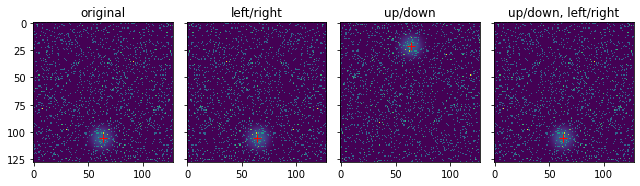

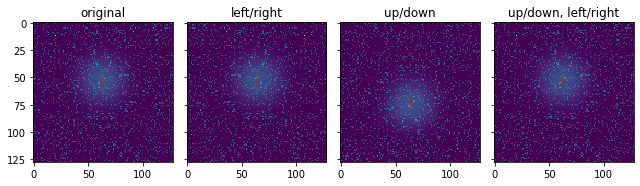

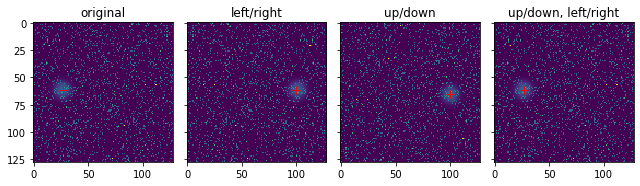

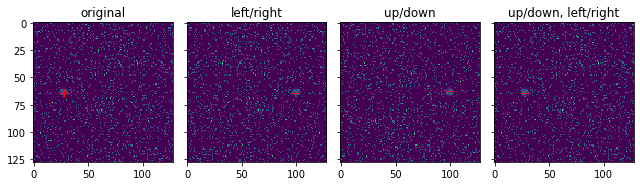

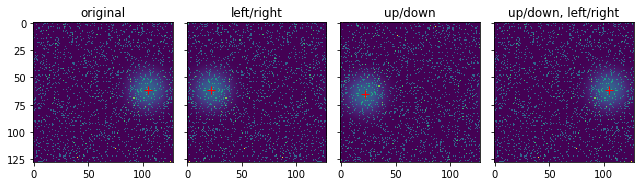

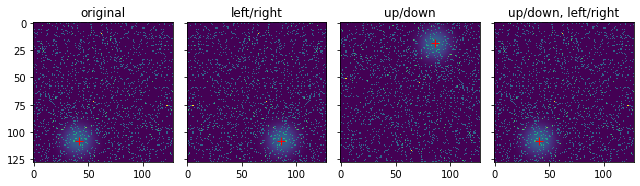

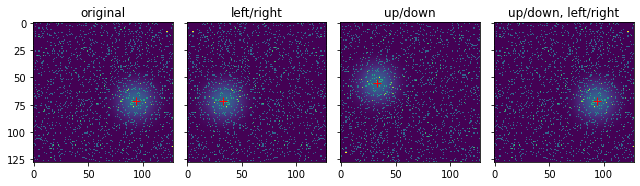

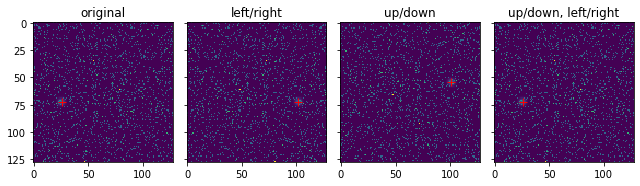

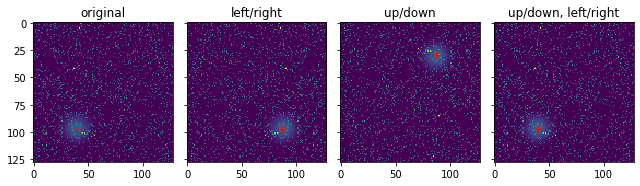

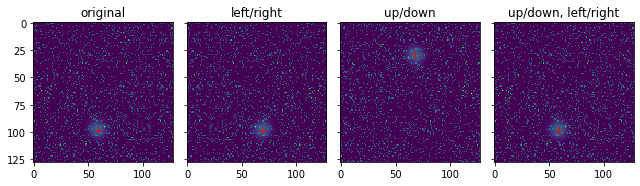

In [3]:
miniset = []
for i in range(10):
    
    std = np.random.randint(low=2,high=15,size=1)
    im_size = 128
    fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(9,3),sharey=True,sharex=True)

    x = Profile(std=std,im_size=im_size)
    x.shift()
    x.add_noise()
    # make copy of original profile
    x = copy.copy(x)
    
    # flip all left/right
    x.flip_lr()
    x_lr = copy.copy(x)
    
    # flip all up/down
    x.flip_ud()
    x_ud = copy.copy(x)

    # flip all left/right and up/down
    x.flip_lrud()
    x_lrud = copy.copy(x)

    i = 0
    profiles = [x,x_lr,x_ud,x_lrud]
    for prof, title_str in zip([x,x_lr,x_ud,x_lrud], ['original','left/right','up/down','up/down, left/right']):
        ax[i].imshow(prof.im,interpolation='none',cmap='viridis')
        ax[i].scatter(prof.x,prof.y,color='red',s=50,marker="+",lw=1)
        ax[i].set_title(title_str)
        i += 1
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.savefig('mirror_ex_3.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

In [4]:
def create_set(set_size=1000,im_size=128,noise=True,shift=True,flip=True):
    dataset = []
    for i in range(set_size):
        std = np.random.randint(low=2,high=15,size=1)
        x = Profile(std=std,im_size=im_size)
        if noise:
            x.add_noise()
        if shift:
            x.shift()
        
        if flip:
            # make copy of original profile
            x_copy = copy.copy(x)

            # flip all left/right
            x.flip_lr()
            x_lr = copy.copy(x)

            # flip all up/down
            x.flip_ud()
            x_ud = copy.copy(x)

            # flip all left/right and up/down
            x.flip_lrud()
            x_lrud = copy.copy(x)
            
            dataset.extend([x_copy,x_lr,x_ud,x_lrud])
            
        else:
            dataset.append(x)
    return np.array(dataset)

In [5]:
def load_dataset(dataset,norm=True):
    # fit the keras model on the dataset
    size = len(dataset)
    data = np.array([prof.im for prof in dataset])
    labels = np.array([(prof.x,prof.y) for prof in dataset])

    idx = np.arange(0,size,1)
    #train_idx = np.delete(idx, test_idx)
    train_idx = idx
    
    im_size = dataset[0].im.shape[0]
    if norm:
        norm_factor = im_size
    else:
        norm_factor = 1
    
    x_train, y_train = data[train_idx], labels[train_idx]/im_size
    x_train = x_train.reshape(-1, im_size, im_size, 1)
    
    return x_train, y_train

In [6]:
dataset = create_set()
x_train, y_train = load_dataset(dataset)

In [7]:
dataset[0].std[0]

10